# Bayesian Optimization (Part 1)

This is the first blog post of a series that introduces the concept of Bayesian optimization (BO). BO is part of the analysis and optimization toolkit of JCMsuite and is regularly used to optimize photonic structures. The optimization of photonic structures is in general very challenging, mainly because of two reasons:
* The behavior of the objective functions is only known implicitly because their evaluations require the full solution of Maxwell’s equation. That is, one has to optimize an **expensive black-box function**.
* The optical behavior of small photonic structures (e.g. the scattering in certain direction) is dominated by diffraction, interference and resonance phenomena. This leads often to a **highly oscillatory** behavior of the objective function.

<div class="figure"><img src="images/black_box.png"/></div>

It turns out, that BO is a very efficient method for the optimization of such expensive black-box functions. That is, compared with many other optimization methods, it requires a much smaller number of function evaluation in order to finds the global optimum or a very good local optimum of the objective function. In many scenarios, this can save many hours to days of computation time.

## Gaussian Process

Bayesian optimization uses a stochastic model of the objective function in order to find promising parameter values. The most commonly applied model is a Gaussian process. The first part of the series explains Gaussian processes and Gaussian process regression. 

First, let's recover the properties of Gaussian random variables:

<div class="box">
    <h3>Definition: Gaussian random variables</h3>

A <b>Gaussian random variable</b> $Y$ is completely specified by its mean $m=\mathbb{E}[Y]$ and standard deviation $\sigma^2=\mathbb{E}[(Y-m)^2]$. The probability density is given by:
$$ P(Y) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[\frac{-(Y-m)^2}{2\sigma^2}\right]$$

A <b>multivariate Gaussian random variable</b> $\mathbf{Y}$ is completely specified by the mean vector $\mathbf{\mu}=\mathbb{E}[\mathbf{Y}]$
and the (symmetric and positive definite) covariance matrix $\mathbf{\Sigma}$ with the entries $\Sigma_{ij}=\mathbb{E}[(Y_i-\mu_i)(Y_j-\mu_j)]$. The probability density is given by:
$$ P(\mathbf{Y}) = \frac{1}{(2\pi)^{k/2}|\Sigma|^{1/2}}\exp\left[-\frac{1}{2}(\mathbf{Y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{Y}-\mathbf{\mu})\right] $$

The short notation for drawing a vector from such a multivariate normal distribution is $ \mathbf{Y} \sim \mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$.
</div>

A Gaussian process is an extension of the concept of Gaussian random variables to a random function where all selections of function values follow a multivariate Gaussian distribution.

<div class="box">
    <h3>Definition: Gaussian process</h3>

A Gaussian process (GP) is a stochastic process defined on a continuous domain $\mathcal{X} \subset \mathbb{R}^n$. 

A random function $f$ is a GP, if for any finite tuple $\mathbf{X}=(x_1, \cdots, x_k) \in \mathcal{X}^k$ the random vector $\mathbf{Y}=[f(x_1), \cdots, f(x_k)]^T$ is a multivariate Gaussian random variable.

A GP is completely specified by a mean function $\mu(x)$ and a covariance function $k(x,x')$ [also denoted as kernel]. That is, the multivariate probability distribution is given by

$$ P(\mathbf{Y}) = \frac{1}{(2\pi)^{k/2}|\Sigma|^{1/2}}\exp\left[-\frac{1}{2}(\mathbf{Y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{Y}-\mathbf{\mu})\right] $$

with $\mathbf{\mu} = \left[\mu(x_1),\cdots,\mu(x_k)\right]^T$, $\mathbf{\Sigma} = [\Sigma_{ij}] = \left[k(x_i,x_j)\right]$.
    </div>

Historically, a process signifies a temporal process. Here, the domain will be defined, e.g., by feasible parameter combinations of a photonic structure.

For random function values at two points $x,x'\in \mathcal{X}$ the following properties follow directly from the properties of the corresponding multivariate Gaussian distribution between the two function values:
* Mean of observation: $\mathbb{E}[f(x)] = \mu(x)$
* Standard deviation of observation:  $$\sigma(x) = \sqrt{\mathbb{E}[(f(x)-\mu(x))^2]} =  \sqrt{k(x,x)}$$
* Covariance between observations: $${\rm cov}[f(x),f(x')] = \mathbb{E}\left[(f(x)-\mu(x))\,(f(x')-\mu(x'))\right] = k(x,x')$$

**Remark** In the following, we only consider stationary kernels for which $k(x,x')$ only depends of the difference vector $x-x'$.

### Example

Let us consider the simple case of a one dimensional domain $\mathcal{X}=[-6,6]$ with a constant mean function
$\mu(x) = 0$
and two different covariance functions, an exponential function
$k_1(x,x') = \exp\left(-|x - x'|\right)$,
and a squared exponential function
$k_2(x,x') = \exp\left(-\frac{(x - x')^2}{2}\right)$.
Then a drawn tuple oscillates around zero as shown in the following code example: 

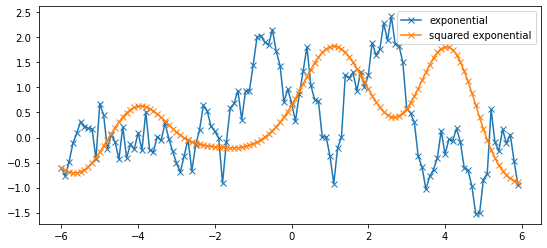

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

#Samples x1...x_k  
X = np.arange(-6,6,0.1)

#Mean vector of zeros
mu = np.zeros_like(X)

#Covariance matrices
dist = np.array([[np.abs(x-y) for x in X] for y in X])
Sigma1 = np.exp(-dist)
Sigma2 = np.exp(-0.5*dist**2)

#Cholesky decompositions of covariance matrices Sigma = L L^T (see explanation below)
eps = 1e-10*np.eye(len(X))
L1 = linalg.cholesky(Sigma1+eps, lower=True)
L2 = linalg.cholesky(Sigma2+eps, lower=True)

#Random vector
u = np.random.normal(loc=0.0, scale=1.0, size=len(X))

#Random Y vectors
Y1 = mu + L1.dot(u)
Y2 = mu + L2.dot(u)

fig = plt.figure(figsize=(9, 4)) 
plt.plot(X, Y1, 'x-',label='exponential')
plt.plot(X, Y2, 'x-',label='squared exponential')
plt.legend()
plt.show()

In order to draw a random vector, we have decomposed the covariance matrix $\mathbf{\Sigma}$ into a lower triangular matrix $\mathbf{L}$ and its transpose $\mathbf{L}^T$. This so-called Cholesky decomposition $\mathbf{\Sigma}=\mathbf{L}\mathbf{L}^T$ exists for every symmetric positive-definite matrix.

For $\mathbf{u}\sim\mathcal{N}(0,\mathbb{1})$ the entries of the random vector $\mathbf{Y} = \mathbf{\mu} + \mathbf{L} \mathbf{u}$ follow the desired mean and covariance, i.e.
$$ \mathbb{E}\left[\mathbf{Y}\right] = \mathbb{E}\left[\mathbf{\mu} + \mathbf{L} \mathbf{u}\right] = \mathbf{\mu} + \mathbf{L} \mathbb{E}\left[\mathbf{u}\right] = \mathbf{\mu}$$
$$ \mathbb{E}\left[(\mathbf{Y}-\mathbf{\mu})(\mathbf{Y}-\mathbf{\mu})^T\right] = \mathbb{E}\left[\mathbf{L}\mathbf{u}\mathbf{u}^T \mathbf{L}^T\right] = \mathbf{L} \mathbb{E}\left[\mathbf{u} \mathbf{u}^T\right] \mathbf{L}^T = \mathbf{L} \mathbb{1} \mathbf{L}^T = \mathbf{\Sigma} $$

If the sampling density becomes too high, the rows of the covariance matrix $\mathbf{\Sigma}$ are almost linearly dependent. Because of the finite numerical resolution, $\mathbf{\Sigma}$ gets ill-conditioned and the Cholesky decomposition fails. In order to improve the condition number of the covariance matrix, one can add a small value $\epsilon$ to the diagonal of the matrix (in the code above $\epsilon=10^{-10}$). This is often referred to as "nugget regularization". In fact, this numerical problem can often arise when dealing with Gaussian processes. Either, one has to avoid a too dense sampling or one has to use regularization techniques such as performing a nugget regularization or a singular value decomposition.

A more convenient way to draw samples from a multivariate Gaussian distribution, is to use the built-in <code>scipy</code> functionality <code>np.random.multivariate_normal</code>.

 ### Matérn covariance function

Both examples above are often not very realistic representations of random processes appearing in nature since one is not differentiable and the other if infinitely often differentiable.

An important covariance function in the context of stochastic processes is the Matérn covariance function 
$$ k_{\nu}(x, x') =  \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}}\left[
         \sqrt{2\nu} d(x , x' )
         \right]^\nu K_\nu\left(
         \sqrt{2\nu} d(x , x' )\right), $$
where $\sigma$ determines the standard deviation of observations, $K_{\nu}(\cdot)$ is a modified Bessel function, and $\Gamma(\cdot)$ is the gamma function. 

As a unit-less measure for the distance, we consider the scaled Euclidean distance
$$ d(x , x' ) = \sqrt{\sum_{i=1}^d \frac{(x_i-x_i')^2}{l_i^2}},$$
where $l_1, \cdots, l_d$ determines the characteristic length scales for the $d$ parameters.
For half-integer $\nu$ the Matérn functions simplify e.g. to
* $k_{1/2}(x , x' ) = \sigma^2\exp\left(-d\right)$,
* $k_{3/2}(x , x' ) = \sigma^2\left(1+\sqrt{3}d\right)\exp\left(-\sqrt{3}d\right)$,
* $k_{5/2}(x , x' ) = \sigma^2\left(1+\sqrt{5}d+\frac{5}{3}d^2\right)\exp\left(-\sqrt{5}d\right)$.

Let's see how samples of these three Matérn covariance functions look like:

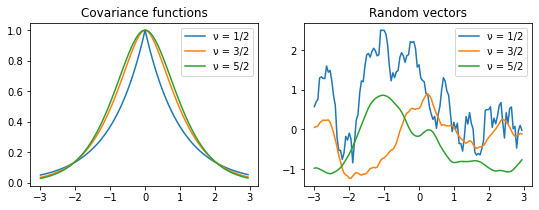

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Samples x1...x_k
X = np.arange(-3,3,0.05)

#mean vector of zeros
mu = np.zeros_like(X)

#Covariance matrices for sigma = l = 1
dist = np.array([[np.abs(x-y) for x in X] for y in X])
Sigma1 = np.exp(-dist)
Sigma2 = (1+np.sqrt(3)*dist)*np.exp(-np.sqrt(3)*dist)
Sigma3 = (1+np.sqrt(5)*dist + 5/3*dist**2)*np.exp(-np.sqrt(5)*dist)

#Samples drawn from a multivariate normal distribution 
Y1 = np.random.multivariate_normal(mu, Sigma1, 1).T
Y2 = np.random.multivariate_normal(mu, Sigma2, 1).T
Y3 = np.random.multivariate_normal(mu, Sigma3, 1).T

fig = plt.figure(figsize=(9, 3)) 
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_title('Covariance functions')
idx_zero = int(len(X)/2)
ax1.plot(X, Sigma1[idx_zero,:], '-',label='ν = 1/2')
ax1.plot(X, Sigma2[idx_zero,:], '-',label='ν = 3/2')
ax1.plot(X, Sigma3[idx_zero,:], '-',label='ν = 5/2')
ax1.legend()
ax2.set_title('Random vectors')
ax2.plot(X, Y1, '-',label='ν = 1/2')
ax2.plot(X, Y2, '-',label='ν = 3/2')
ax2.plot(X, Y3, '-',label='ν = 5/2')
ax2.legend()
plt.show()

As one can see, the smoothness of the random functions and their differentiability depend on the smoothness and differentiability of the covariance functions. We will come back later to this point. Before, we discuss how we can incorporate prior knowledge about certain function values into the probability distribution of the Gaussian process.   

<h2> Optimization of hyperparameters</h2>

Initially the hyperparameters of the kernel $\omega = (\sigma,l_1,l_2,\cdots)$ are not known. 
However, having drawn some samples of the function one can optimize the hyperparameters 
by maximizing the probability of drawing these samples with respect to the value 
of the hyperparameters:

\begin{equation}
\begin{split}
\omega_{\rm opt} &= \underset{\omega}{\operatorname{arg\,max}}\left(\log[P_\omega(\mathbf{Y})\cdot P(\omega)]\right) \\
                 &= \underset{\omega}{\operatorname{arg\,max}}\left(-\frac{1}{2}\log(|\mathbf{\Sigma}|)-\frac{1}{2}(\mathbf{Y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{Y}-\mathbf{\mu}) + \log[P(\omega)]\right)
\end{split}
\end{equation}

Here, $P(\omega)$ is the hyperprior of the hyperparameters and $P_\omega(Y)$ the likelyhood of observing $Y$ given $\omega$.

The following code example determines the hyperparameters of the simple one dimensional function $f(x) = 0.5\sin(0.8x+0.5)+0.015x^2-0.5$:

Maximum likelihood obtained for sigma = 0.8 and l = 2.9


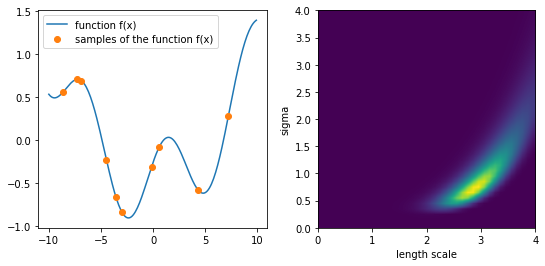

In [3]:
from scipy.linalg import det
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

#samples to determine log likelihood
samples = np.random.uniform(-10,10,10)

#objective function
def f(x): return 0.5*np.sin(0.8*x+0.5)+0.015*x**2-0.5
Y = f(samples)

def log_likelihood(omega):
    Sigma = np.array(
        [[(omega[0]**2)*np.exp(-0.5*((x-y)/omega[1])**2) for x in samples] for y in samples]
    )
    return -0.5*np.log(det(Sigma)) - 0.5 * Y@np.linalg.inv(Sigma)@Y

sigmas = np.arange(4.01,0.01,-0.1)
lengths = np.arange(0.01,4.01,0.1)
ll = np.array([
    [np.exp(log_likelihood([sigma,l])) for l in lengths] 
    for sigma in sigmas])

idx_max = np.unravel_index(np.argmax(ll),ll.shape)
print('Maximum likelihood obtained for sigma = {:.1f} and l = {:.1f}'.format(
    sigmas[idx_max[0]],
    lengths[idx_max[1]]
))

fig = plt.figure(figsize=(9, 4)) 
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
X = np.arange(-10,10,0.1)
ax1.plot(X,f(X),'-',label='function f(x)')
ax1.plot(samples,Y,'o',label='samples of the function f(x)')
ax1.legend()
im = ax2.imshow(ll, interpolation="bilinear", extent=(0, 4, 0, 4))
ax2.set_xlabel("length scale")
ax2.set_ylabel("sigma")
plt.show()

## Gaussian process regression (GPR)

Let us consider a tuple of input vectors of length $k_1$ and $k_2$ with corresponding mean vector and covariance matrix

$$ \mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \mathbf{X}_2 \end{bmatrix}\;
\mathbf{\mu} = \begin{bmatrix} \mathbf{\mu}_1 \\ \mathbf{\mu}_2 \end{bmatrix}\;
\mathbf{\Sigma} = \begin{bmatrix} \mathbf{\Sigma}_{11} & \mathbf{\Sigma}_{12} \\ \mathbf{\Sigma}_{21} & \mathbf{\Sigma}_{22} \end{bmatrix}
$$ 

Now, we are interested in the probability distribution of $\mathbf{Y}_2$ given that we know a set of function values $\mathbf{Y}_1$. This conditional probability is by definition given as $$P(\mathbf{Y}_2 | \mathbf{Y}_1)=\frac{P(\mathbf{Y}_1,\mathbf{Y}_2)}{P(\mathbf{Y}_1)}.$$

The probability densities for the output vector $\mathbf{Y}_1$ and the joint output vector $\mathbf{Y} = [\mathbf{Y}_1, \mathbf{Y}_2]^T$ are, of course, given as 
\begin{eqnarray}
P(\mathbf{Y}_1) &=& \frac{1}{(2\pi)^{(k_1)/2}|\mathbf{\Sigma}_{11}|^{1/2}}\exp\left[-\frac{1}{2}(\mathbf{Y}_1-\mathbf{\mu}_1)^T\mathbf{\Sigma}_{11}^{-1}(\mathbf{Y}_1-\mathbf{\mu}_1)\right] \\
P(\mathbf{Y}_1,\mathbf{Y}_2) = P(\mathbf{Y}) &=& \frac{1}{(2\pi)^{(k_1+k_2)/2}|\mathbf{\Sigma}|^{1/2}}\exp\left[-\frac{1}{2}(\mathbf{Y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{Y}-\mathbf{\mu})\right]
\end{eqnarray}


After some linear algebra one finds 
\begin{eqnarray}
 P(\mathbf{Y}_2 | \mathbf{Y}_1) &=& \frac{1}{(2\pi)^{k_2/2}|\Sigma'|^{1/2}}\exp\left[-\frac{1}{2}(\mathbf{Y}_2-\mathbf{\mu}')^T\mathbf{\Sigma'}^{-1}(\mathbf{Y}_2-\mathbf{\mu}')\right]\;\text{with}\\
 \mathbf{\mu}' &=& \mathbf{\mu}_2 + \mathbf{\Sigma}_{21}\mathbf{\Sigma}_{11}^{-1}(\mathbf{Y}_1-\mathbf{\mu}_1)\\
 \mathbf{\Sigma}' &=& \mathbf{\Sigma}_{22} - \mathbf{\Sigma}_{21}\mathbf{\Sigma}^{-1}_{11}\mathbf{\Sigma}_{12}
\end{eqnarray}
That means, the conditional probability $P(\mathbf{Y}_2 | \mathbf{Y}_1)$ also follows that of a Gaussian process with the posterior mean vector $\mathbf{\mu}'$ and the covariance matrix $\mathbf{\Sigma}'$.

For a complete proof see: http://fourier.eng.hmc.edu/e161/lectures/gaussianprocess/node7.html

In the following, we draw some random samples from the posterior Gaussian process. As one can see, all samples conform with the known function values: 

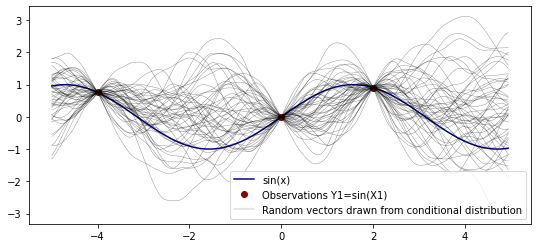

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Samples for X1 and X2
X1 = np.array([-4,0,2])
X2 = np.arange(-5,5,0.05)

#Known function values from a sin function
Y1 = np.sin(X1)

#zero mean vector for X1 and X2
mu1 = np.zeros_like(X1)
mu2 = np.zeros_like(X2)
 
# As kernel we use the Matern 5/2 covariance function
def k(x,y): return (1+np.sqrt(5)*abs(x-y) + 5/3*(x-y)**2)*np.exp(-np.sqrt(5)*abs(x-y))

#Covariance matrices
Sigma11 = np.array([[k(x,y) for x in X1] for y in X1])
Sigma12 = np.array([[k(x,y) for x in X2] for y in X1])
Sigma21 = Sigma12.T
Sigma22 = np.array([[k(x,y) for x in X2] for y in X2])

# mean vector and covariance matrix for conditional process
mu = mu2 + Sigma21@np.linalg.inv(Sigma11)@(Y1-mu1)
Sigma = Sigma22 - Sigma21@np.linalg.inv(Sigma11)@Sigma12

#Samples drawn from a multivariate normal distribution
Y2 = np.random.multivariate_normal(mu, Sigma, 50).T
fig = plt.figure(figsize=(9, 4)) 
plt.plot(X2, np.sin(X2), '-',color='darkblue',label='sin(x)')
plt.plot(X1, Y1, 'o',color='darkred',label='Observations Y1=sin(X1)')
plt.plot(X2, Y2[:,0], '-',linewidth=0.4,color='black',alpha=0.5,label='Random vectors drawn from conditional distribution')
plt.plot(X2, Y2[:,1:], '-',linewidth=0.4,color='black',alpha=0.5)
plt.legend()
plt.show()

In the context of Bayesian optimization, one usually does not need correlated random vectors of function values, but rather the probability distribution of a single function value $y$ at some $x^* \in \mathcal{X}$.

Suppose we know as before the values of an unknown function $f(x)$ at some positions $\mathbf{X} = [x_1,x_2,\cdots]^T$

Setting $\mathbf{X}_1=\mathbf{X}$, $\mathbf{X}_2 = [x^*]^T$ and $\mathbf{Y}_2 = [y]^T$ we see that this is simply a normal distribution $y\sim \mathcal{N}( \overline{y},\sigma^2)$ with mean and standard deviation

\begin{eqnarray}
\overline{y}(x^*) &=& \mu(x^*) + \sum_{ij} k(x^*,x_i) \mathbf{\Sigma}^{-1}_{i j}[f(x_j)-\mu(x_j)] \\
\sigma^2(x^*) &=& k(x^*,x^*) - \sum_{ij} k(x^*,x_i) \mathbf{\Sigma}^{-1}_{i j} k(x_j,x^*)
\end{eqnarray}

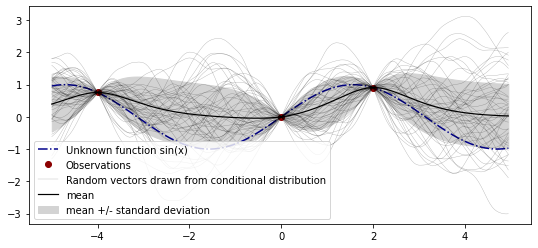

In [5]:
#
# Please, evaluate the cell above before evaluating this cell
#
fig = plt.figure(figsize=(9, 4)) 
plt.plot(X2, np.sin(X2), '-.',color='darkblue',label='Unknown function sin(x)')
plt.plot(X1, Y1, 'o',color='darkred',label='Observations')
plt.plot(X2, Y2[:,0], '-',linewidth=0.4,color='black',alpha=0.3,label='Random vectors drawn from conditional distribution')
plt.plot(X2, Y2[:,1:], '-',linewidth=0.4,color='black',alpha=0.3)
#the mean of each X2 is simply the corresponding entry of the mean vector
plt.plot(X2, mu, '-',linewidth=1.2,color='black',label='mean')
#the squared standard deviations are the diagonal entries of Sigma 
sdev = np.sqrt(np.abs(np.diag(Sigma)))
plt.fill_between(X2, mu-sdev, mu+sdev, color='lightgrey',label='mean +/- standard deviation')
plt.legend()#bbox_to_anchor=(1, 1))
plt.show()

### Properties of posterior mean function and sampling paths
Let us come back to the connection between the properties of the covariance function $k$ of a Gaussian process and the smoothness of the probability distribution of the Gaussian process. There are two important connections:
* The posterior GPR mean function lies in the corresponding reproducing kernel Hilbert space (RKHS) 
\begin{equation}
\mathcal{H}_k = \left\{ f=\sum_i c_i k(\cdot,x_i) : c_i \in \mathbb{R}, x_i\in \mathcal{X}, \text{such that} \left\lVert f\right\rVert = \sum_{i j} c_i c_j k(x_i,x_j) < \infty \right\}
\end{equation}
  That is, the mean function $\overline{y}(x^*)$ has the same smoothness as the kernel. 
  For details, see the very good overview about the connection between 
  Gaussian processes and reproducing kernel Hilbert spaces: 
  [Kanagawa, Motonobu, et al. "Gaussian processes and kernel methods: A review on connections and equivalences."](https://arxiv.org/abs/1807.02582)

* If $k(x,x')$ has a finite $2k^{\rm th}$ order derivative $\frac{\partial^{2k} k(x,x')}{\partial x_{i_1}^2\cdots\partial x_{i_k}^2}$ at $x=x'$, the derivative $\frac{\partial^k f(x)}{\partial x_{i_1}\cdots\partial x_{i_k}}$ of a sample path exists for all $x$. Here, the derivative of sample paths is defined in the means-square limit. Roughly, this means that the sample path smoothness is 1/2 times smaller than that of the kernel for $x=x'$. For example, the Matérn-$5/2$ kernel is two times differentiable and hence all sampling paths are one time differentiable in the mean-square limit. For details, see chap. 4 of [Carl Edward Rasmussen and Christopher K. I. Williams "Gaussian Processes for Machine Learning"](http://www.gaussianprocess.org/gpml/chapters/).

## Derivative observations

A practical property of Gaussian processes is the ability to incorporate not only function observations, but also observations of function derivatives. This is possible, because differentiation and integration can be exchanged.

As we know, a Gaussian process is completely determined by its mean and covariance function. So, we have to find the mean and covariance function for the derivative of a function $\nabla_x f(x)$.

If a random function $f(x)$ is a Gaussian process, the mean function of $\nabla_x f(x)$ is by definition
  $$\mu_D \equiv \mathbb{E}[\nabla f(x)]=\nabla \mathbb{E}[ f(x)] = \nabla \mu(x)$$

The covariance function (i.e. the kernel) between an observation of $f(x)$ and a derivative observation at $\nabla_{x'} f(x')$ is 
$$k_D(x,x') \equiv {\rm cov}(f(x),\nabla_{x'} f(x')) = \mathbb{E}\left[(f(x)-\mu(x))(\nabla_{x'} f(x'))\right] = \nabla_{x'} \mathbb{E}\left[(f(x)-\mu(x))(f(x')-\mu(x')\right] = \nabla_{x'} k(x,x')$$

Analogously, the kernel function between a derivative observation $\nabla_{x} f(x)$ and a derivative observation $\nabla_{x'} f(x')$ is given as $$ k_{DD}(x,x') \equiv {\rm cov}\left(\nabla_x f(x), \nabla_{x'} f(x')\right) = \nabla_x \nabla_{x'} k(x,x')$$

In the most cases were we consider physical processes, the unknown objective function is everywhere continuous and one time differentiable. That means, it is always possible to make derivative observations (even if we don't make use of them). Hence, the kernel must be two times differentiable. For Matérn covariance functions, this holds for $\nu\geq 5/2$. On the other hand, for $\nu \geq 7/2$ the Matérn function is already very close to a squared-exponential kernel, which often leads to an overly smooth behavior of the mean function and the sampling paths. Therefore, the Matérn-5/2 kernel is often a very good choice to describe physically motivated objective functions. 

The following code implements a small python class <code>GaussianProcess</code>. It gives a simple recipe for the adding data regarding functions values or derivatives to a Gaussian process and to make numerically stable predictions afterwards.

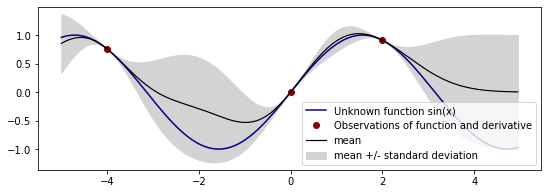

In [6]:
import numpy as np
import scipy
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib inline

class GaussianProcess(object):
    def __init__(self,sigma=1.0,l=1.0):
        self.sigma=sigma
        self.l=l
        self.X = []
        self.y = []
        self.deriv = []
        
    def kernel(self,x,x2,deriv,deriv2):
        k = self.sigma**2*np.exp(-0.5*(x-x2)**2/self.l**2)
        if deriv==deriv2==0: return k
        kD =(x-x2)/self.l**2 * k 
        if deriv==0 and deriv2==1: return kD 
        if deriv==1 and deriv2==0: return -kD
        kDD = k/self.l**2 - (x-x2)/self.l**2*kD
        return kDD
        
    def add(self,x,y,deriv):
        self.X.append(x)
        self.y.append(y)
        self.deriv.append(deriv)
        
    def prepare(self):
        Sigma = np.zeros((len(self.y),len(self.y)))
        for idx in range(len(self.y)):
            for idy in range(len(self.y)):
                Sigma[idx,idy] = self.kernel(
                    self.X[idx],self.X[idy],
                    self.deriv[idx],self.deriv[idy])
                
        # Computing the inverse of the covariance matrix Sigma is numerically unstable. 
        # Therfore, we do a Cholesky decomposition instead.
        self.L = scipy.linalg.cholesky(Sigma, lower=True)
        # alpha = Sigma^-1*Y
        self.alpha = scipy.linalg.cho_solve((self.L, True), np.atleast_2d(self.y).T)
        
    def predict(self,xstar):
        
        # vector of [k(xstar,x_i)]_i
        Kstar = np.array([
            self.kernel(xstar,x2,0,deriv2) for x2,deriv2 in zip(self.X,self.deriv)])
            
        # mu = Kstar * Sigma^-1 * Y = Kstar * alpha
        mu = Kstar.dot(self.alpha)[0]
            
        #compute L^-1 Kstar
        v = scipy.linalg.solve_triangular(self.L, Kstar.T, lower=True)
        # sigma^2 = k(xstar,xstar) - Kstar^T * Sigma^-1 * Kstar = v^T * v
        sigma_sq = self.kernel(xstar,xstar,0,0) - v.T.dot(v)
        
        return mu, np.sqrt(sigma_sq)

#instance of Gaussian process with sigma = l = 1
gp = GaussianProcess()

#Samples for X1 and X2
X1 = np.array([-4,0,2])
X2 = np.arange(-5,5,0.05)

#Known function values from a sin function
Y1 = np.sin(X1)

for x in X1: 
    gp.add(x,np.sin(x),0)
    gp.add(x,np.cos(x),1)

gp.prepare()

predictions = np.array([gp.predict(x) for x in X2])
mu = predictions[:,0]
sdev = predictions[:,1]

fig = plt.figure(figsize=(9, 3)) 
plt.plot(X2, np.sin(X2), '-',color='darkblue',label='Unknown function sin(x)')
plt.plot(X1, Y1, 'o',color='darkred',label='Observations of function and derivative')
plt.plot(X2, mu, '-',linewidth=1.2,color='black',label='mean')
plt.fill_between(X2, mu-sdev, mu+sdev, color='lightgrey',label='mean +/- standard deviation')

plt.legend()
plt.show()

## Conclusion

Gaussian process regression is a valuable surrogate model of expensive black-box functions. It can incorporate all previous observations (also derivative observations) to predict a function values for any parameter values. moreover, it also tells us an uncertainty range of the prediction. In the next part of this series we will see that this information is crucial to perform a very efficient optimization of photonic devices using Bayesian optimization. 

Gaussian process regression is one of the fundamental tools of the [Analysis and Optimization Toolkit](https://www.docs.jcmwave.com/JCMsuite/html/PythonInterface/25402383e25cfabd3ea18fdc2daef540.html) of JCMsuite.

## Additional Resources

* Download a [free trial version](https://installation.jcmwave.com/fb13885794fc64c42531c9656f8f6f73.php) of JCMsuite.
* [Tutorial example](https://www.docs.jcmwave.com/JCMsuite/html/PythonInterface/5a0a3035bcff4b3580fb76ded6711bfc.html) on Bayesian optimization based on Gaussian process regression.
* Documentation of JCMsuite's **Analysis and Optimization Toolkit** for [Python](https://www.docs.jcmwave.com/JCMsuite/html/PythonInterface/25402383e25cfabd3ea18fdc2daef540.html) and [Matlab](https://www.docs.jcmwave.com/JCMsuite/html/MatlabInterface/25402383e25cfabd3ea18fdc2daef540.html).
* Publication on benchmark of Bayesian optimization against other optimization methods:
  Schneider, P. I., Garcia Santiago, X., Soltwisch, V., Hammerschmidt, M., Burger, S., & Rockstuhl, C. (2019). *Benchmarking five global optimization approaches for nano-optical shape optimization and parameter reconstruction*. **ACS Photonics**, 6(11), 2726-2733. ([arXiv link](https://arxiv.org/abs/1809.06674))
* A great reference for Gaussian process regression is the website http://www.gaussianprocess.org/.
